In [20]:
# Goal: Test if the oxygen model works by generating models using the new method and then comparing
# with the observed spectra
import sys, os
import numpy as np
import matplotlib.pyplot as plt
try:
    import snelib19odp
except ImportError:
    sys.path.append('../lib')
import snelib19odp.analysis.oxygen as oxygen
import snelib19odp.specds as specds

In [21]:
sds = specds.load_dataset('SN2019odp')

In [22]:
obj = 'keck_early'
obj_write = True

if obj == 'keck_early':
    spec = sds['ZTF19abqwtfu_20200124_Keck1_v1']
elif obj == 'keck_late':
    spec = sds['ZTF19abqwtfu_20200821_Keck1_v1']
elif obj == 'not_late':
    spec = sds['ZTF19abqwtfu_20200113_NOT_v1']
    
def plot_spec(name, wave_min, wave_max):
    if name == 'keck_early':
        s = sds['ZTF19abqwtfu_20200124_Keck1_v1']
    elif name == 'keck_late':
        s = sds['ZTF19abqwtfu_20200821_Keck1_v1']
    elif name == 'not_late':
        s = sds['ZTF19abqwtfu_20200113_NOT_v1']
    s = s[~np.isnan(s['flux'])]
    idx = np.logical_and(s['restwave'] > wave_min, s['restwave'] < wave_max)
    plt.plot(s['restwave'][idx], s['flux'][idx])

#spec = dataloader.load_obs_spec('ZTF19abqwtfu_20200124_Keck1_v1.ascii', fluxcal=False)

#
spec = spec[~np.isnan(spec['flux'])]
#spec

In [34]:
#if obj in ['keck_early']:
    #cfg = oxygen.FitSetup(spec=spec, smp=1, start5577=5520, stop5577=5669, start6300_6364=6100, stop6300_6364=6500, extra_lines=np.array([6158, 6230]), max_width=25)
#cfg_keck_early = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=27, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1, max_extra_line_amp=3e-14)
cfg_keck_early = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([]), max_width=27, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/7.002413899090286e-18, nlte_departure_max=0.1, max_extra_line_amp=3e-14)

#elif obj == 'not_late':
cfg_not_late = oxygen.FitSetup(spec=spec, smp=1, start5577=5400, stop5577=5650, start6300_6364=6100, stop6300_6364=6540, extra_lines=np.array([5500, 6158, 6230, 6454]), max_width=27, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/9.395640563324519e-18, nlte_departure_max=0.1, max_extra_line_amp=3e-14)
# For the late Keck spectrum:
#elif obj == 'keck_late':
cfg_keck_late = oxygen.FitSetup(spec=spec, smp=1, start5577=5520, stop5577=5669, start6300_6364=6150, stop6300_6364=6450, extra_lines=np.array([6225]), max_width=22, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/3.031557125203086e-18, nlte_departure_max=0.05, max_extra_line_amp=3e-14)
cfg_keck_late_noline = oxygen.FitSetup(spec=spec, smp=1, start5577=5520, stop5577=5669, start6300_6364=6150, stop6300_6364=6450, extra_lines=np.array([]), max_width=22, nlte_mode=1, max_continuum=0.5e-15, scale_factor=np.sqrt(2)/3.031557125203086e-18, nlte_departure_max=0.05, max_extra_line_amp=3e-14)



In [32]:
# some parameters from the automated fit
keck_results = np.array([ 4.01230343e+00,  4.70449308e+03,  2.67075211e+01,  1.63512609e+01,
        1.61440673e+01,  8.87172107e-03, -4.68064047e-03,  1.98120381e+26,
       -6.94225275e+00,  2.12916075e+00, -2.44450965e+00, 0.3])

keck_results_late = np.array([ 2.68671543e+00,  3.18859805e+03,  2.50110138e+01,  2.15215893e+00,
        3.08472235e+00,  3.05936196e-03,  4.73564460e-03,  1.98012288e+26,
       -4.18201257e-01,  8.79838039e-01, -2.01166321e+00,  2.76087819e-01]
)

In [70]:
def plot_result(p, cfg, spec, idx, label=None, tweaks={}):
    p = np.array(p, copy=True)
    for i in tweaks.keys():
        p[i] = tweaks[i]
    extra_idx = cfg.extra_lines > 6000
    line_width = p[2]#*1.3
    wlen_offset = p[8]
    #line_skew = p[12]
    #p[9] -= 3

    continuum_level_5577 = p[3]/cfg.scale_factor
    continuum_level_6300_6364 = p[4]/cfg.scale_factor

    continuum_slope_5577 = p[5]/cfg.scale_factor
    continuum_slope_6300_6364 = p[6]/cfg.scale_factor
    
    extra_lines_amps = np.exp(p[12:])/cfg.scale_factor
    
    fluxes = oxygen.create_fluxes(p)
    amplitude_5577 = fluxes[0]
    amplitude_6300 = fluxes[1]
    amplitude_6364 = fluxes[2]
    print(fluxes)
    
    #print(spec['restwave'][idx]+wlen_offset)
    modflux = np.empty(len(spec['restwave'][idx]))
    for j in range(len(modflux)):
        modflux[j] = oxygen.generation_func_6300_6364((spec['restwave'][idx]+wlen_offset)[j], continuum_level_6300_6364, continuum_slope_6300_6364, amplitude_6300, amplitude_6364, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    plt.plot(spec['restwave'][idx], modflux, label=label)
    
def plot_result_5577(p, cfg, spec, idx, label=None, tweaks={}):
    p = np.array(p, copy=True)
    for i in tweaks.keys():
        p[i] = tweaks[i]
    extra_idx = cfg.extra_lines < 6000
    
    oxygen_mass = p[0]
    lte_temp = p[1]

    line_width = p[2]
    #line_skew = p[12]

    continuum_level_5577 = p[3]/cfg.scale_factor
    continuum_level_6300_6364 = p[4]/cfg.scale_factor

    continuum_slope_5577 = p[5]/cfg.scale_factor
    continuum_slope_6300_6364 = p[6]/cfg.scale_factor

    distance = p[7]

    wlen_offset = p[8]

    line_ratio = p[9]
    
    extra_lines_amps = np.exp(p[12:])/cfg.scale_factor

    fluxes = oxygen.create_fluxes(p)
    #fluxes = create_fluxes(p)
    
    amplitude_5577 = fluxes[0]
    amplitude_6300 = fluxes[1]
    amplitude_6364 = fluxes[2]
    
    modflux = np.empty(len(spec['restwave'][idx]))
    for j in range(len(modflux)):
        modflux[j] = oxygen.generation_func_5577(spec['restwave'][idx][j]+wlen_offset, continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    #modflux = modfunc(spec['restwave'][idx]+wlen_offset, continuum_level_5577, continuum_slope_5577, amplitude_5577, line_width, cfg.extra_lines[extra_idx], extra_lines_amps[extra_idx])
    plt.plot(spec['restwave'][idx], modflux, label=label)

In [88]:
plt.figure(figsize=(11,11))

idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6600)
#idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6200)
plt.plot(spec['restwave'][idx], spec['flux'][idx])

plot_result(keck_results, cfg_keck_early, tweaks={9: 1.3, 1: 11e3, 0: 0.4, 8:0, 9: 1.5, 2:25})
plt.axvline(6300)
plt.axvline(6300-6, ls='--')
plt.axvline(6364)
plt.axvline(6364+6, ls='--')

[1.59107311e-15 1.64055242e-14 1.24219591e-14]


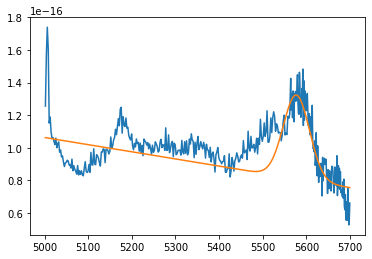

In [84]:
idx = np.logical_and(spec['restwave'] > 5000, spec['restwave'] < 5700)
plt.plot(spec['restwave'][idx], spec['flux'][idx])
plot_result_5577(keck_results, cfg_keck_early, idx, tweaks={9: 1.3, 1: 11e3, 0: 0.3, 8:0, 9: 0.9, 2:30, 11: 0.4})

In [58]:
#@numba.njit(inline='always')
def create_lums(p):
    oxygen_mass = p[0]
    lte_temp = p[1]
    optical_depth = p[9]
    beta_ratio = p[11]

    # estimate line fluxes given oxygen mass and lte_temp
    flux_5577 = oxygen.calculate_line_luminosity_5577(oxygen_mass, lte_temp, optical_depth, beta_ratio)
    flux_6300 = oxygen.calculate_line_luminosity_63xx(oxygen_mass, lte_temp, optical_depth, 6300)
    flux_6364 = oxygen.calculate_line_luminosity_63xx(oxygen_mass, lte_temp, optical_depth, 6364)
    
    r = np.empty(3)
    r[0] = flux_5577
    r[1] = flux_6300
    r[2] = flux_6364
    
    return r

In [80]:
create_lums(keck_results)/1e38

array([ 2.98306331, 94.35225534, 52.53756467])

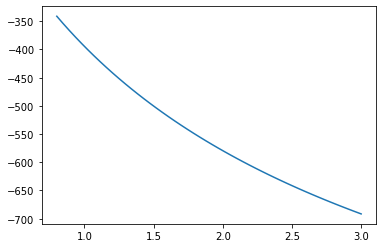

In [39]:
# expected blueshift by optical depth
tau = np.linspace(0.8, 3)
velocity = 27/6300 * 300e3
delta_v = velocity * (-1 + np.log(1+tau)/tau)
plt.plot(tau, delta_v)

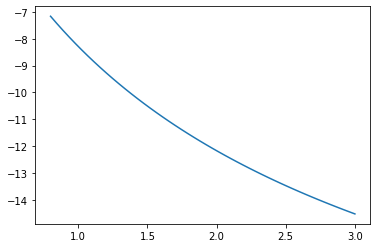

In [40]:
# expected blueshift by optical depth
tau = np.linspace(0.8, 3)
velocity = 27/6300 * 300e3
delta_v = velocity * (-1 + np.log(1+tau)/tau)
z = delta_v / 300e3
delta_l = 6300*z
plt.plot(tau, delta_l)

No handles with labels found to put in legend.


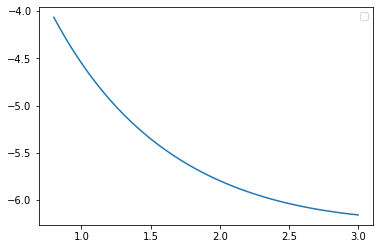

In [45]:
# expected blueshift between 6300 and 6364 by optical depth
tau = np.linspace(0.8, 3)
velocity = 27/6300 * 300e3

delta_v = velocity * (-1 + np.log(1+tau)/tau)
z = delta_v / 300e3
delta_l_6300 = 6300*z

#velocity = 27/6364 * 300e3
delta_v = velocity * (-1 + 3*np.log(1+tau/3)/tau)
z = delta_v / 300e3
delta_l_6364 = 6364*z

plt.plot(tau, delta_l_6300-delta_l_6364)
#plt.plot(tau, delta_l_6300, label='6300')
#plt.plot(tau, delta_l_6364, label='6364')
plt.legend()

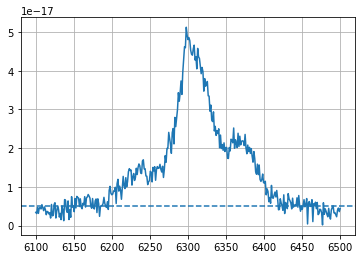

In [15]:
plot_spec('keck_late', 6100, 6500)
plt.grid()
plt.axhline(0.5e-17, ls='--')

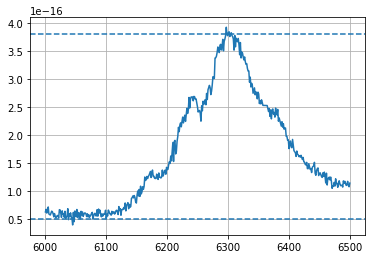

In [13]:
plot_spec('keck_early', 6000, 6500)
plt.grid()
plt.axhline(3.8e-16, ls='--')
plt.axhline(0.5e-16, ls='--')

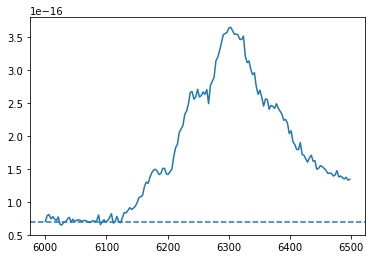

In [18]:
plot_spec('not_late', 6000, 6500)
plt.axhline(0.7e-16, ls='--')

In [68]:
plt.figure(figsize=(11,11))

plot_spec('keck_late', 6100, 6500)
spec = sds['ZTF19abqwtfu_20200821_Keck1_v1']
idx = np.logical_and(spec['restwave'] > 6100, spec['restwave'] < 6500)
plt.grid()
#plt.axhline(0.5e-17, ls='--')
plot_result(keck_results_late, cfg_keck_late_noline, spec, idx, label='Fit Sample')#, tweaks={9: 1.3, 1: 11e3, 0: 0.4, 8:0, 9: 1.5, 2:25})
plot_result(keck_results_late, cfg_keck_late_noline, spec, idx, label='Tau=0.1', tweaks={0: 1.9, 2: 20, 4: 3.0, 6: 0, 8: -5, 9: 0.1})

keck_results_late_extra_line = np.empty(len(keck_results_late)+1)
keck_results_late_extra_line[0:len(keck_results_late)] = keck_results_late
keck_results_late_extra_line[-1] = 5.3
cfg_keck_late_tweak = cfg_keck_late._replace(extra_lines=np.array([6230]))
plot_result(keck_results_late_extra_line, cfg_keck_late_tweak, spec, idx, label='ExtraLine Tau=0.1', tweaks={0: 1.9, 2: 20, 4: 3.0, 6: 0, 8: -5, 9: 0.1})

plt.legend()

[3.18863438e-18 2.04523970e-15 8.57636826e-16]
[2.27623053e-18 2.06955970e-15 6.88250727e-16]
[2.27623053e-18 2.06955970e-15 6.88250727e-16]


In [73]:
plt.figure(figsize=(11,11))

plot_spec('keck_late', 5400, 5700)
spec = sds['ZTF19abqwtfu_20200821_Keck1_v1']
idx = np.logical_and(spec['restwave'] > 5400, spec['restwave'] < 5700)
plt.grid()
#plt.axhline(0.5e-17, ls='--')
plot_result_5577(keck_results_late, cfg_keck_late_noline, spec, idx, label='Fit Sample')#, tweaks={9: 1.3, 1: 11e3, 0: 0.4, 8:0, 9: 1.5, 2:25})
plot_result_5577(keck_results_late, cfg_keck_late_noline, spec, idx, label='Tau=0.1', tweaks={0: 1.9, 2: 20, 4: 3.0, 6: 0, 8: -5, 9: 0.1})

keck_results_late_extra_line = np.empty(len(keck_results_late)+1)
keck_results_late_extra_line[0:len(keck_results_late)] = keck_results_late
keck_results_late_extra_line[-1] = 5.3
cfg_keck_late_tweak = cfg_keck_late._replace(extra_lines=np.array([6230]))
plot_result_5577(keck_results_late_extra_line, cfg_keck_late_tweak, spec, idx, label='ExtraLine Tau=0.1', tweaks={0: 1.9, 2: 20, 4: 3.0, 6: 0, 8: -5, 9: 0.1})

plt.legend()